# Build and Train Model

In [1]:
# load packages
import pandas as pd
import numpy as np
import os
import datetime as dt
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import math
import datetime
from sklearn import preprocessing
from utils import *
import pickle
import statsmodels.formula.api as smf
from jupyterthemes import jtplot

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.4f' % x)
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

## Data Visalisation

In [2]:
# load prepared data file (pickle file saved from Data Preparation Step) 
df = pd.read_pickle("1_input/input_rq1.pkl")
TARGETS = ['standard_mortality_label']
labels = [False, True]

# Split prepared data into feature set and target/label set
X = df.drop(['standard_mortality_label'], axis=1) #feature set: drop outcome column
y = df[['standard_mortality_label']] #target set: outcome column

Label Balance in counts:
False    47368
True      3697
Name: standard_mortality_label, dtype: int64
Label Balance in ratio:
False   0.9276
True    0.0724
Name: standard_mortality_label, dtype: float64


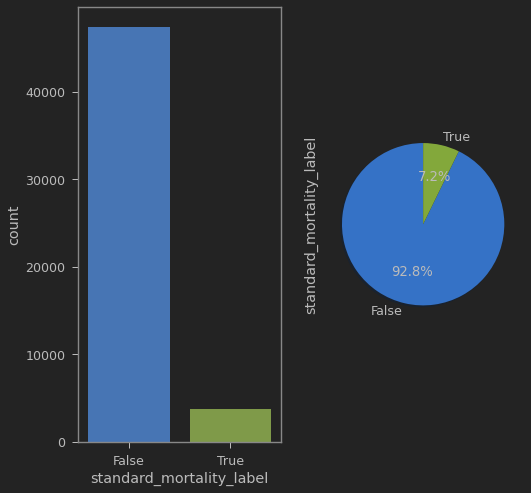

In [3]:
# Label Balance Analysis
fig, ax = plt.subplots(1,2, figsize=(8,8))
sns.countplot(df['standard_mortality_label'], ax=ax[0])
df.standard_mortality_label.value_counts().\
    plot.pie(labels=labels, autopct='%.1f%%', shadow=True, startangle=90)
print('Label Balance in counts:')
print(df.standard_mortality_label.value_counts())
print('Label Balance in ratio:')
print(df.standard_mortality_label.value_counts(normalize=True))

## Model Evaluation, Training and Validation

In [4]:
# Traning and test set split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data into training and test sets (3:1 ratio) with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size = 0.25, stratify = y)

# Normalise feature for baseline model
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save training set
# Traning Features
trainingset_file = '2_training/training.pkl'
scaled_training_file = '2_training/training_scaled.pkl'
pickle.dump(X_train, open(trainingset_file, 'wb')) # save pre-normalisation
pickle.dump(X_train_scaled, open(scaled_training_file, 'wb')) # save normalised
# Traning Labels
traininglabel_file = '2_training/training_label.pkl'
pickle.dump(y_train, open(traininglabel_file, 'wb')) 

# Save test set
# Test Features
testset_file = '2_validation/test.pkl'
scaled_test_file = '2_validation/test_scaled.pkl'
pickle.dump(X_test, open(testset_file, 'wb')) # save pre-normalisation
pickle.dump(X_test_scaled, open(scaled_test_file, 'wb')) # save normalised
# Test Labels
testlabel_file = '2_training/test_label.pkl'
pickle.dump(y_train, open(testlabel_file, 'wb')) 

print('Traning set size {0} rows, {1} columns'.format(X_train.shape[0], X_train.shape[1]))
print('Validation/test set size {0} rows, {1} columns'.format(X_test.shape[0], X_test.shape[1]))
print('Training / test set size: {0:.2f}'.format(X_train.shape[0]/X_test.shape[0]))
print('Label vector for training size: {0}, for validation: {1}'.format(y_train.shape[0], y_test.shape[0]))

Traning set size 38298 rows, 61 columns
Validation/test set size 12767 rows, 61 columns
Training / test set size: 3.00
Label vector for training size: 38298, for validation: 12767


In [5]:
# packages for model pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
# packages for model performance evaluation
from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score # Area under PR curve
from sklearn.metrics import matthews_corrcoef # Matthews Correlation Coefficient <- for ranking only
from sklearn.metrics import cohen_kappa_score # Cohen's kappa
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import time
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve

# Transformer for pipeline: for normalisation
scaler = StandardScaler()

# Unbalanced dataset
average_precision_scorer = make_scorer(average_precision_score)
f1_scorer = make_scorer(f1_score)
cohens_kappa_scorer = make_scorer(cohen_kappa_score)
matthew_corrcoe_scorer = make_scorer(matthews_corrcoef)
scoring = {'AP': average_precision_scorer,
           'F1': f1_scorer, 
           'CK': cohens_kappa_scorer,
           'MC': matthew_corrcoe_scorer,}



--------Logistic Regression Baseline Model---------


Job took: 0.36867237091064453s
Baseline Model parameters:
 <bound method BaseEstimator.get_params of LogisticRegression(n_jobs=-1, random_state=0, solver='liblinear')>
Best cross-validation score (Accuracy): 0.9437
Accuracy: 0.944 
F1-score: 0.450 
PR_AUC: 0.550 
ROC_AUC: 0.870 

                     feature  importance
38            verbal_no_resp      0.6917
31               tachycardia      0.4013
5            age_bins_over75      0.3388
39                gcs_severe      0.2702
55         abnorm_creatinine      0.2592
53  abnorm_bloodureanitrogen      0.2527
23        adm_type_emergency      0.2500
54  abnorm_partialpressureo2      0.2480
34                abnorm_map      0.2330
42          abnorm_bilirubin      0.2289
49             abnorm_sodium      0.1941
48          abnorm_platelets      0.1935
59            abnorm_lactate      0.1743
47                abnorm_wbc      0.1725
29               abnorm_spo2      0.1671
       

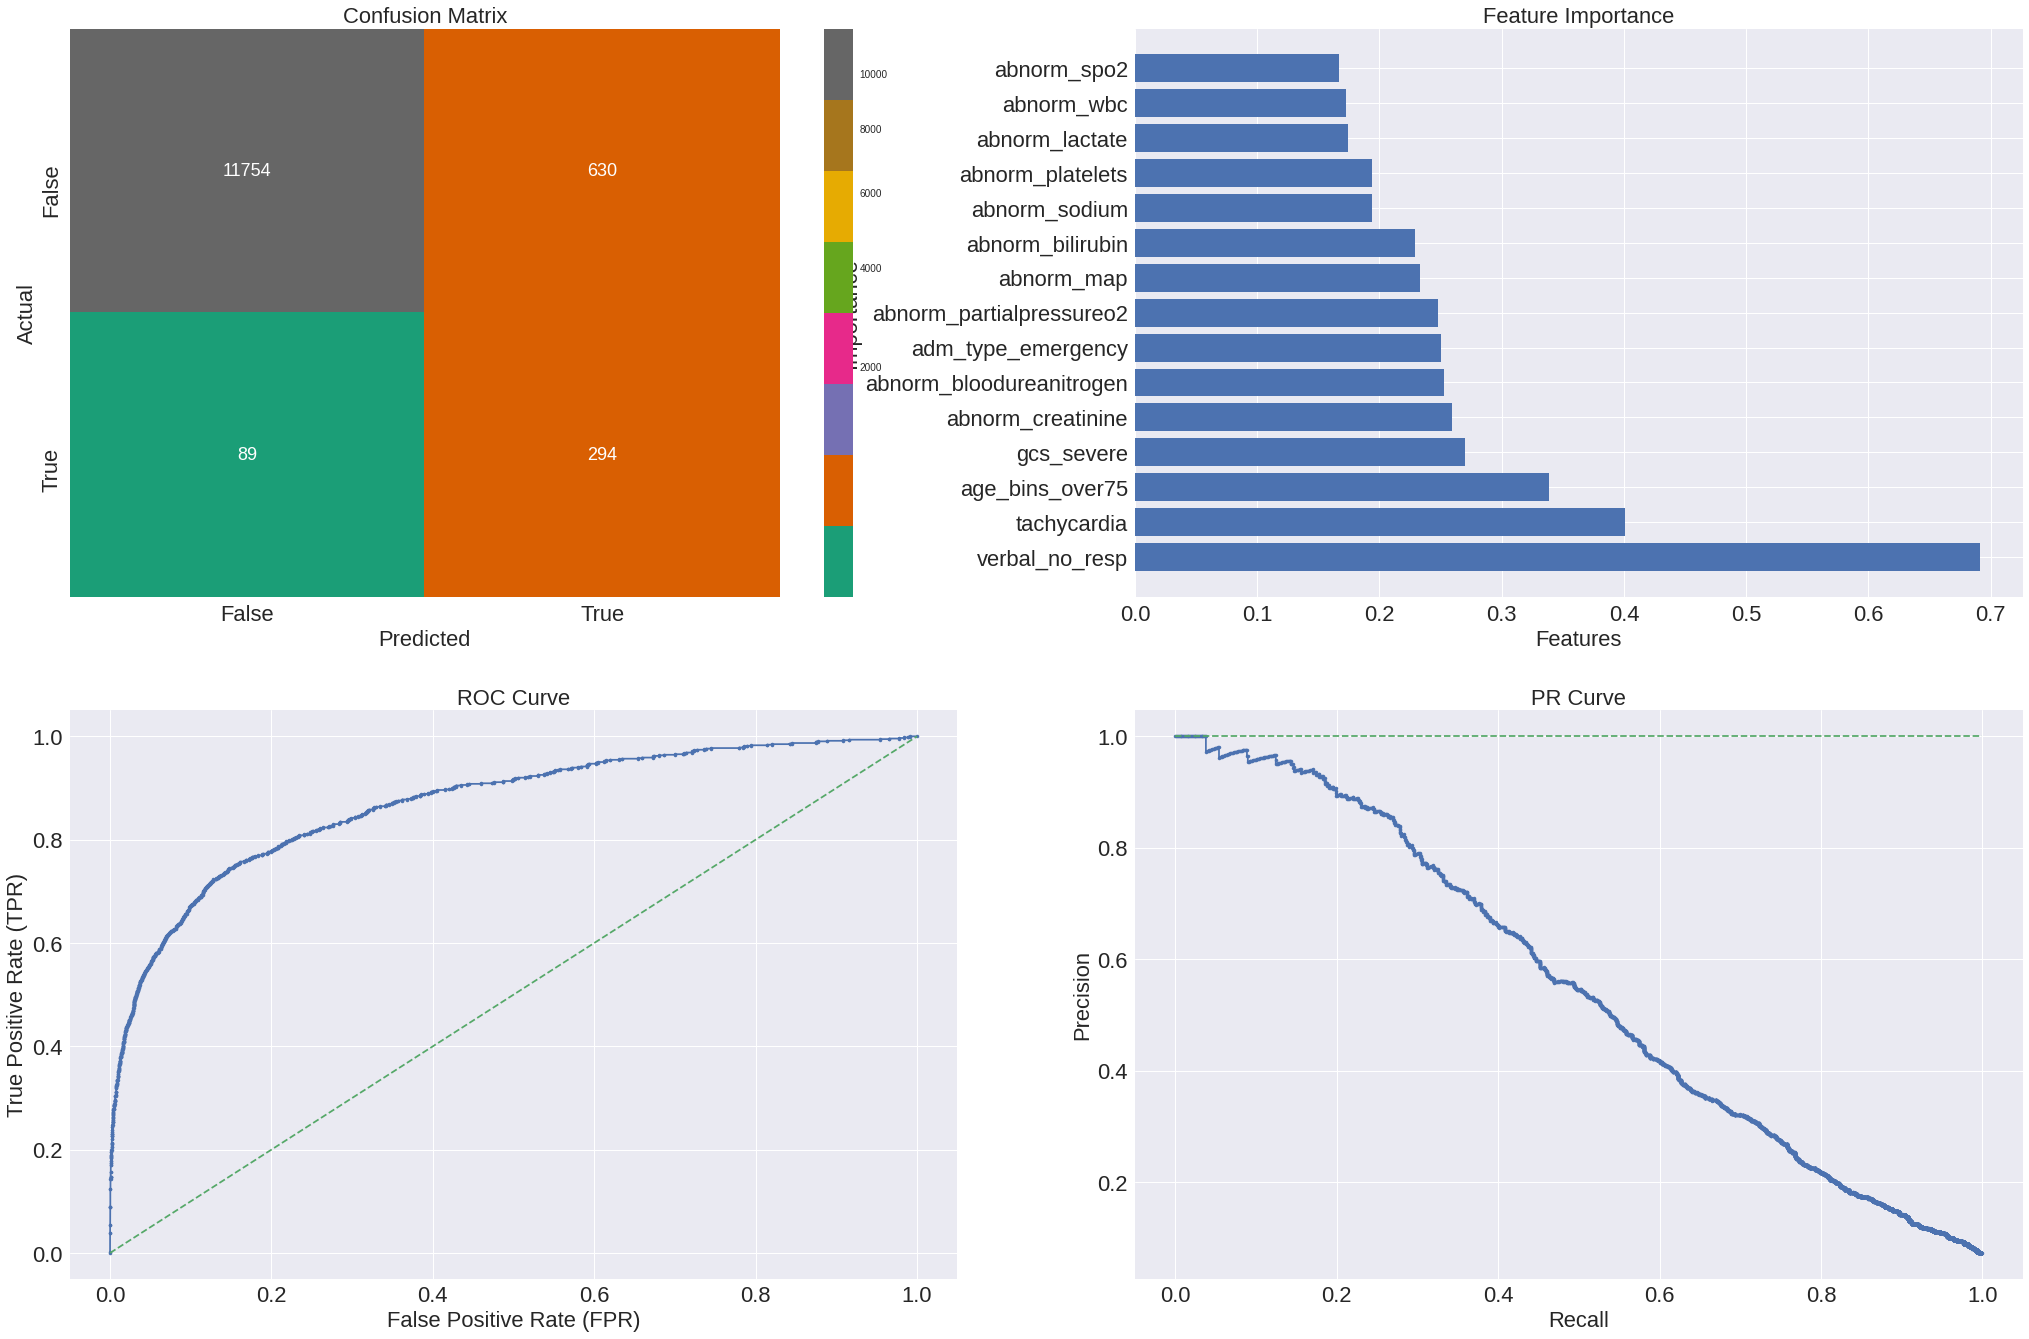



--------Random Forest Baseline Model---------


Job took: 0.4797348976135254s
Baseline Model parameters:
 <bound method BaseEstimator.get_params of RandomForestClassifier(class_weight={0: 87, 1: 12}, n_jobs=-1, random_state=0)>
Best cross-validation score (Accuracy): 0.9493
Accuracy: 0.949 
F1-score: 0.477 
PR_AUC: 0.663 
ROC_AUC: 0.910 

                 feature  importance
14            len_of_adm      0.1672
0                    los      0.1368
40          gcs_moderate      0.0214
13              gender_M      0.0186
16  english_speaker_True      0.0170
48      abnorm_platelets      0.0167
29           abnorm_spo2      0.0167
50       abnorm_chloride      0.0163
49         abnorm_sodium      0.0162
31           tachycardia      0.0161
47            abnorm_wbc      0.0161
59        abnorm_lactate      0.0159
33              diabetes      0.0158
60            abnorm_inr      0.0156
55     abnorm_creatinine      0.0156
              precision    recall  f1-score   support

       Fal

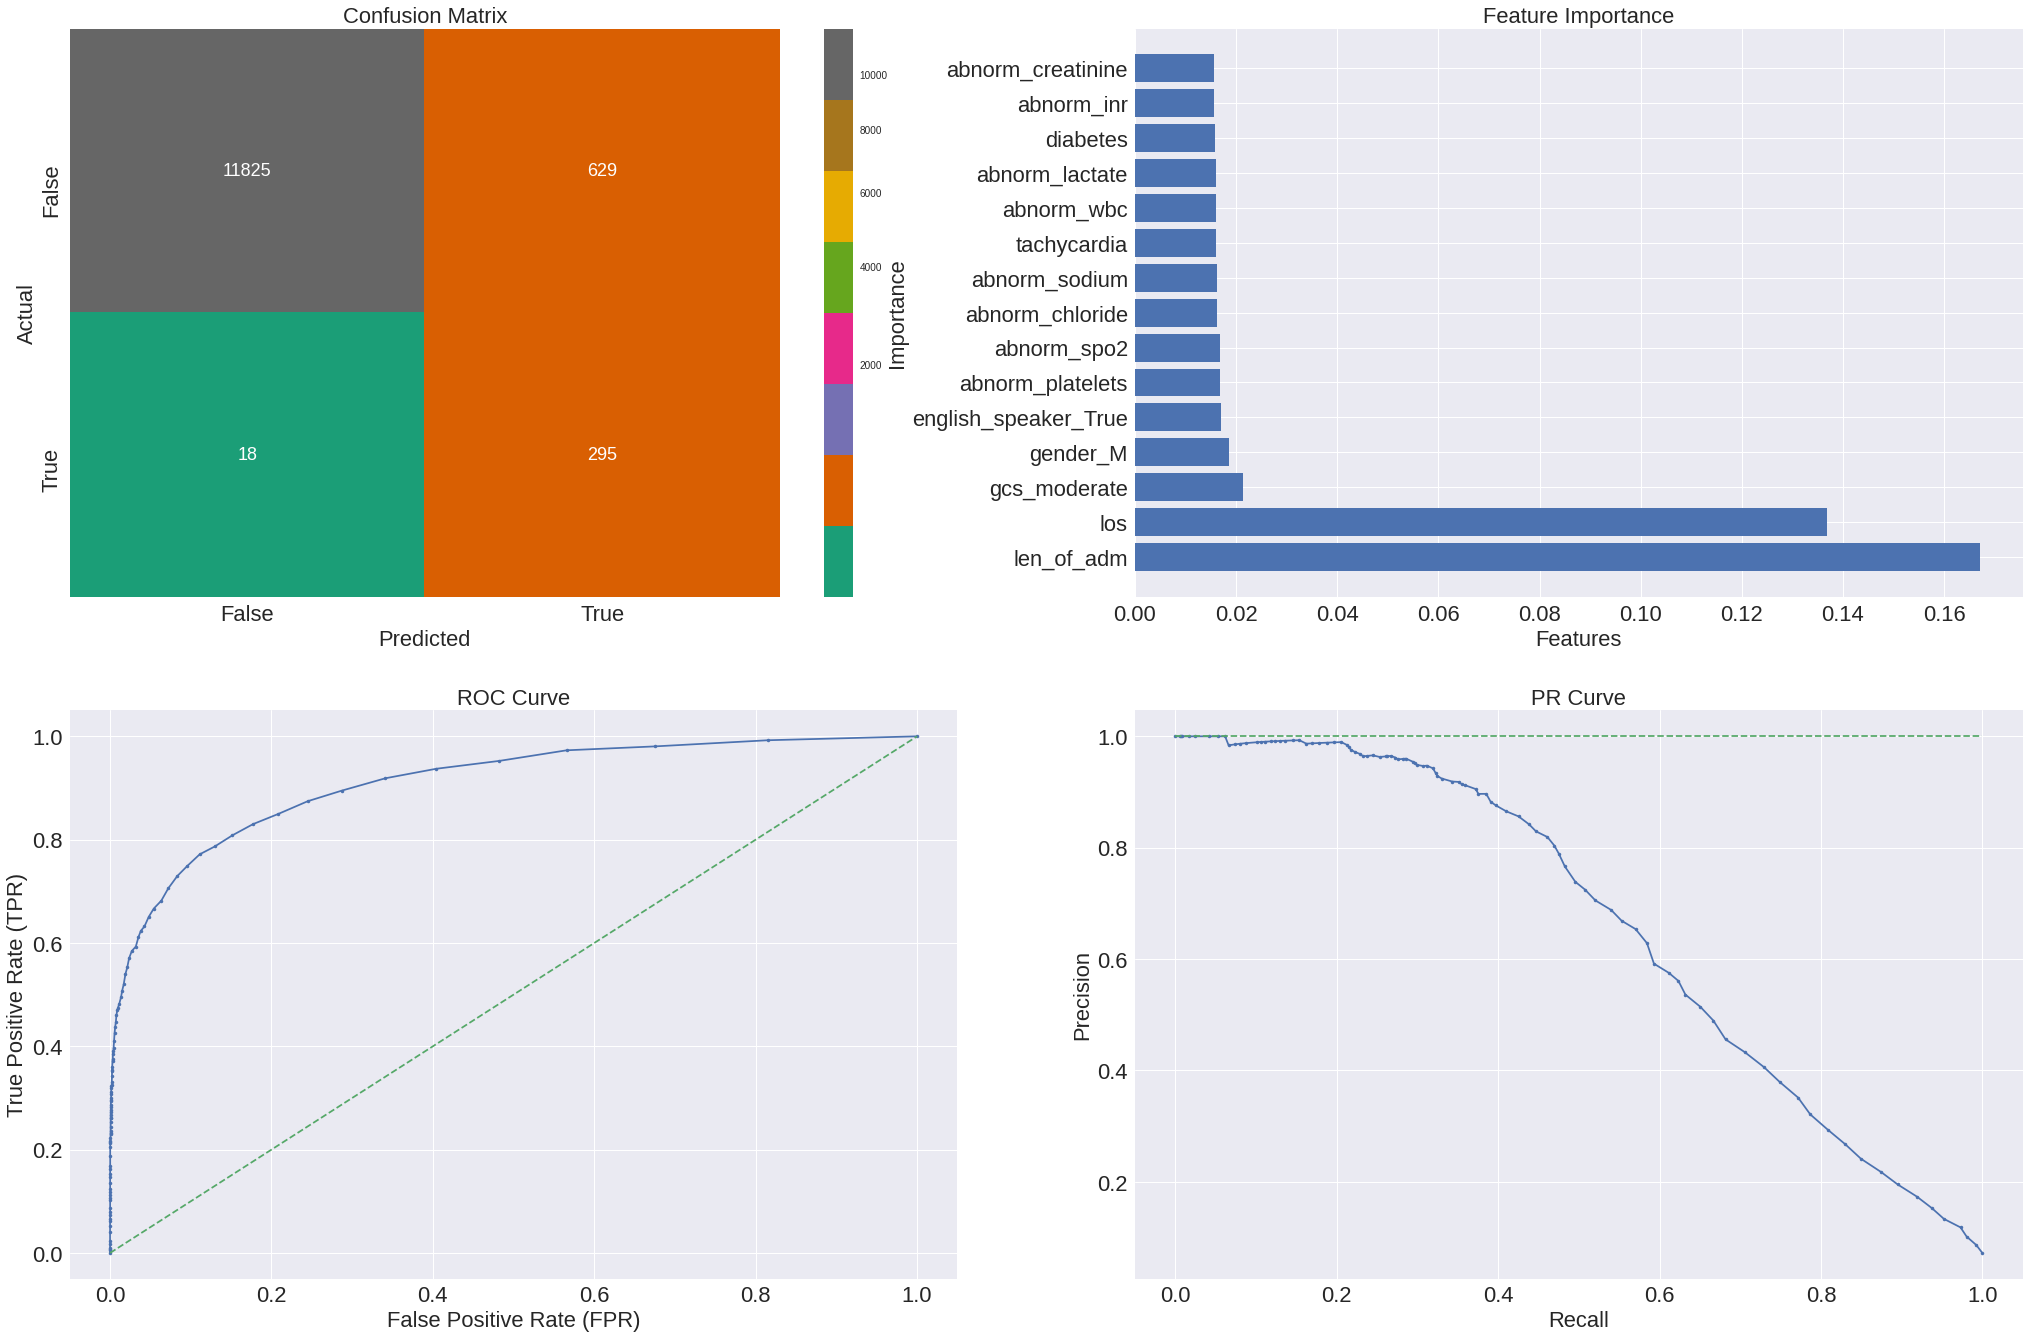



--------Gradient Boosted Tree Baseline Model---------


Job took: 4.804773807525635s
Baseline Model parameters:
 <bound method BaseEstimator.get_params of GradientBoostingClassifier(random_state=0)>
Best cross-validation score (Accuracy): 0.9559
Accuracy: 0.956 
F1-score: 0.599 
PR_AUC: 0.714 
ROC_AUC: 0.933 

                     feature  importance
14                len_of_adm      0.3165
39                gcs_severe      0.2126
0                        los      0.1587
36               eye_no_resp      0.0504
59            abnorm_lactate      0.0352
40              gcs_moderate      0.0319
54  abnorm_partialpressureo2      0.0305
5            age_bins_over75      0.0214
1           age_bins_under44      0.0171
55         abnorm_creatinine      0.0144
53  abnorm_bloodureanitrogen      0.0142
42          abnorm_bilirubin      0.0138
31               tachycardia      0.0105
44                abnorm_ast      0.0089
37             motor_no_resp      0.0077
              precision    rec

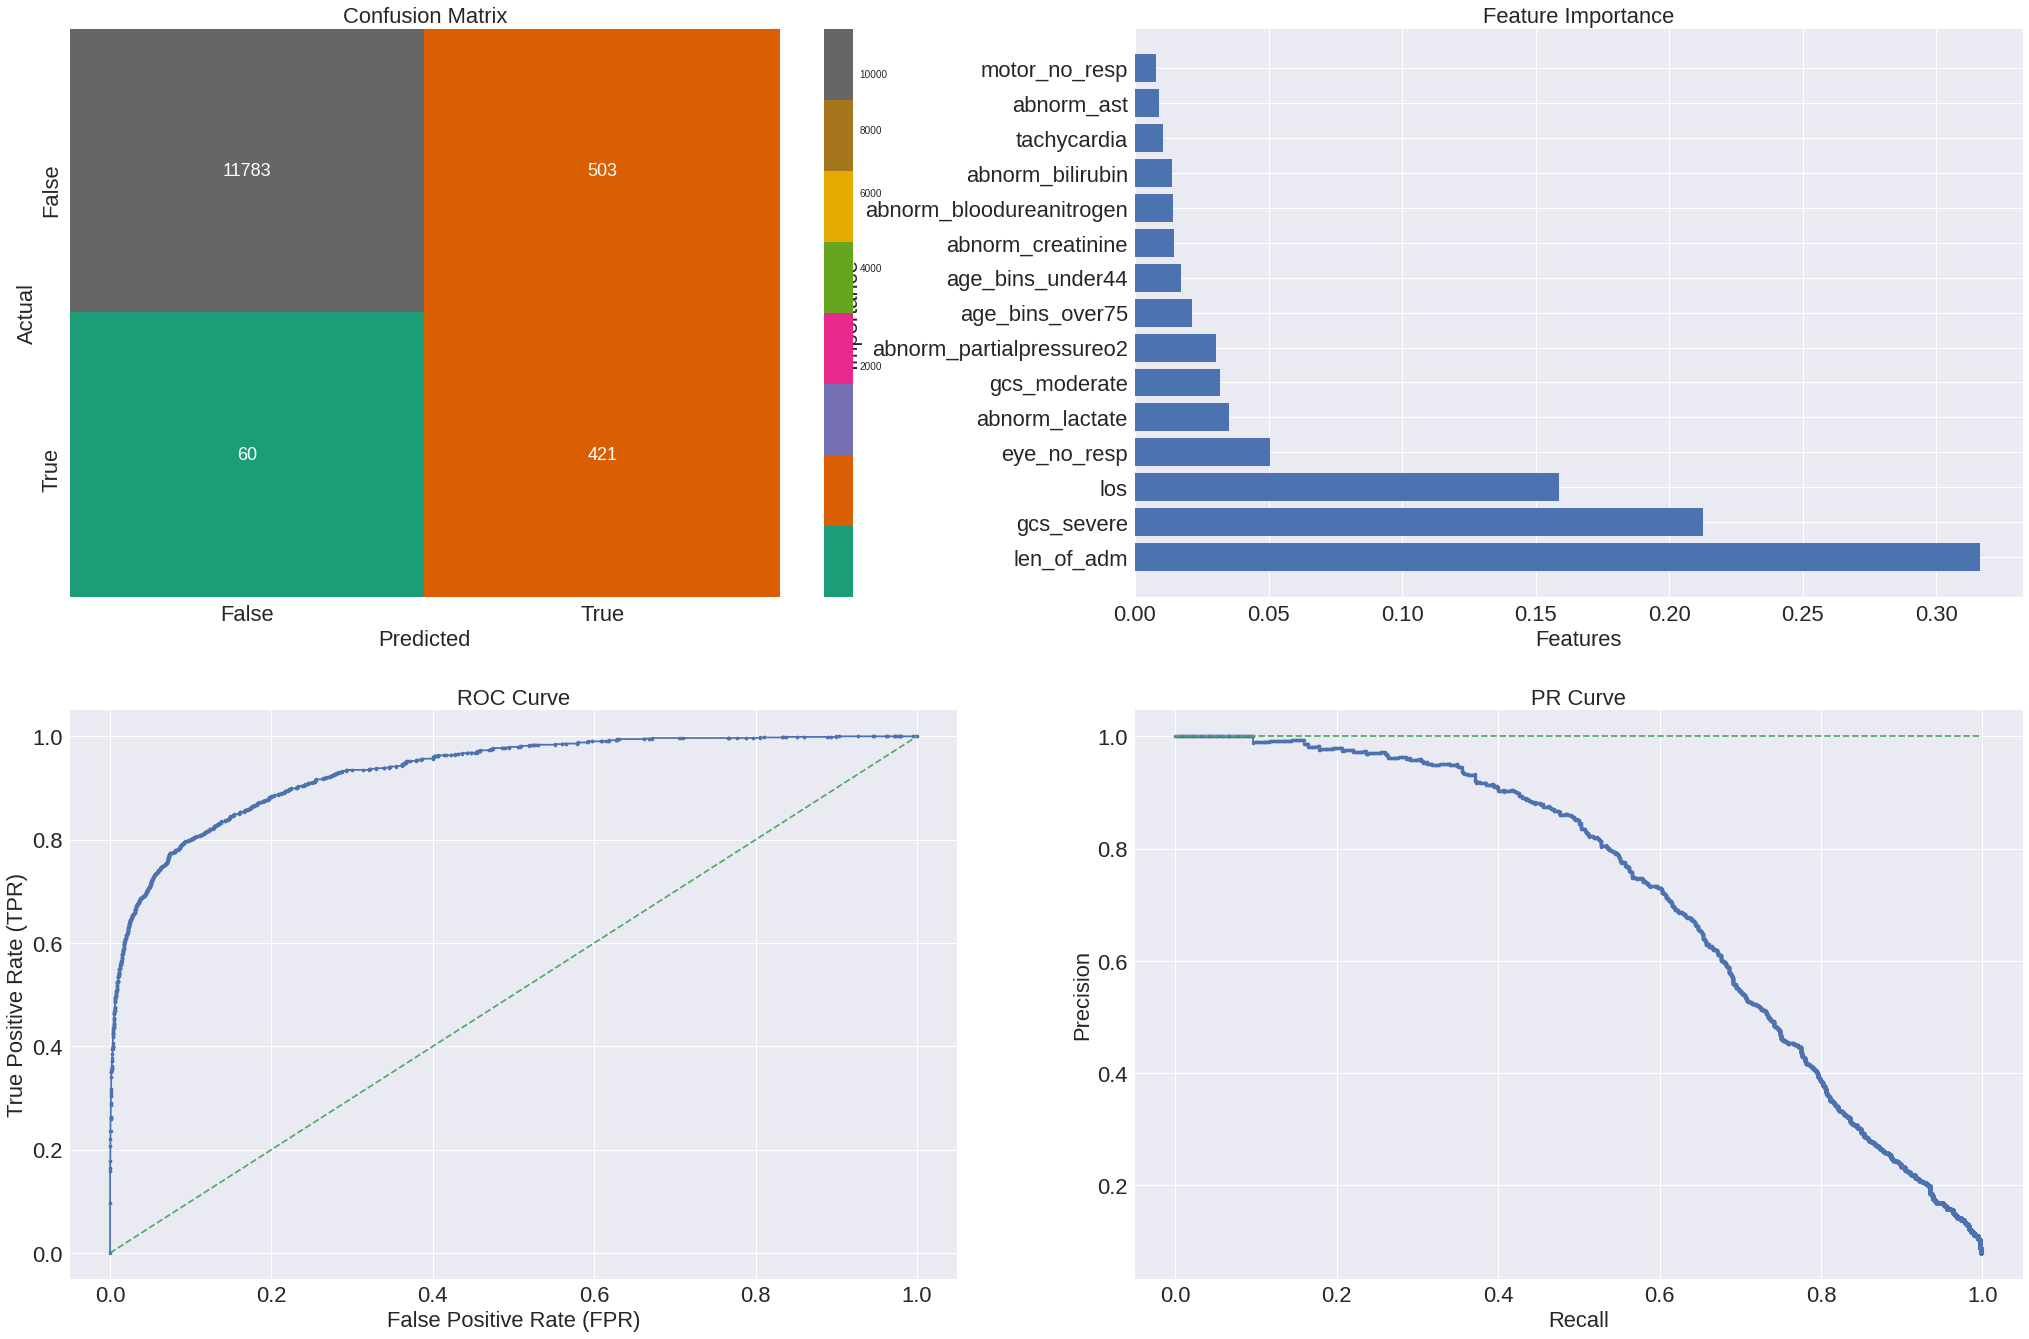



--------XG Boost Baseline Model---------


Job took: 0.7203159332275391s
Baseline Model parameters:
 <bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              eval_metric=['error', 'map', 'aucpr'], gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)>
Best cross-validation score (Accuracy): 0.9575
Accuracy: 0.957 
F1-score: 0.647 
PR_AUC: 0.716 
ROC_AUC: 0.930 

                     feature  importance
39                gcs_severe      0.1448
22         adm_type_electi

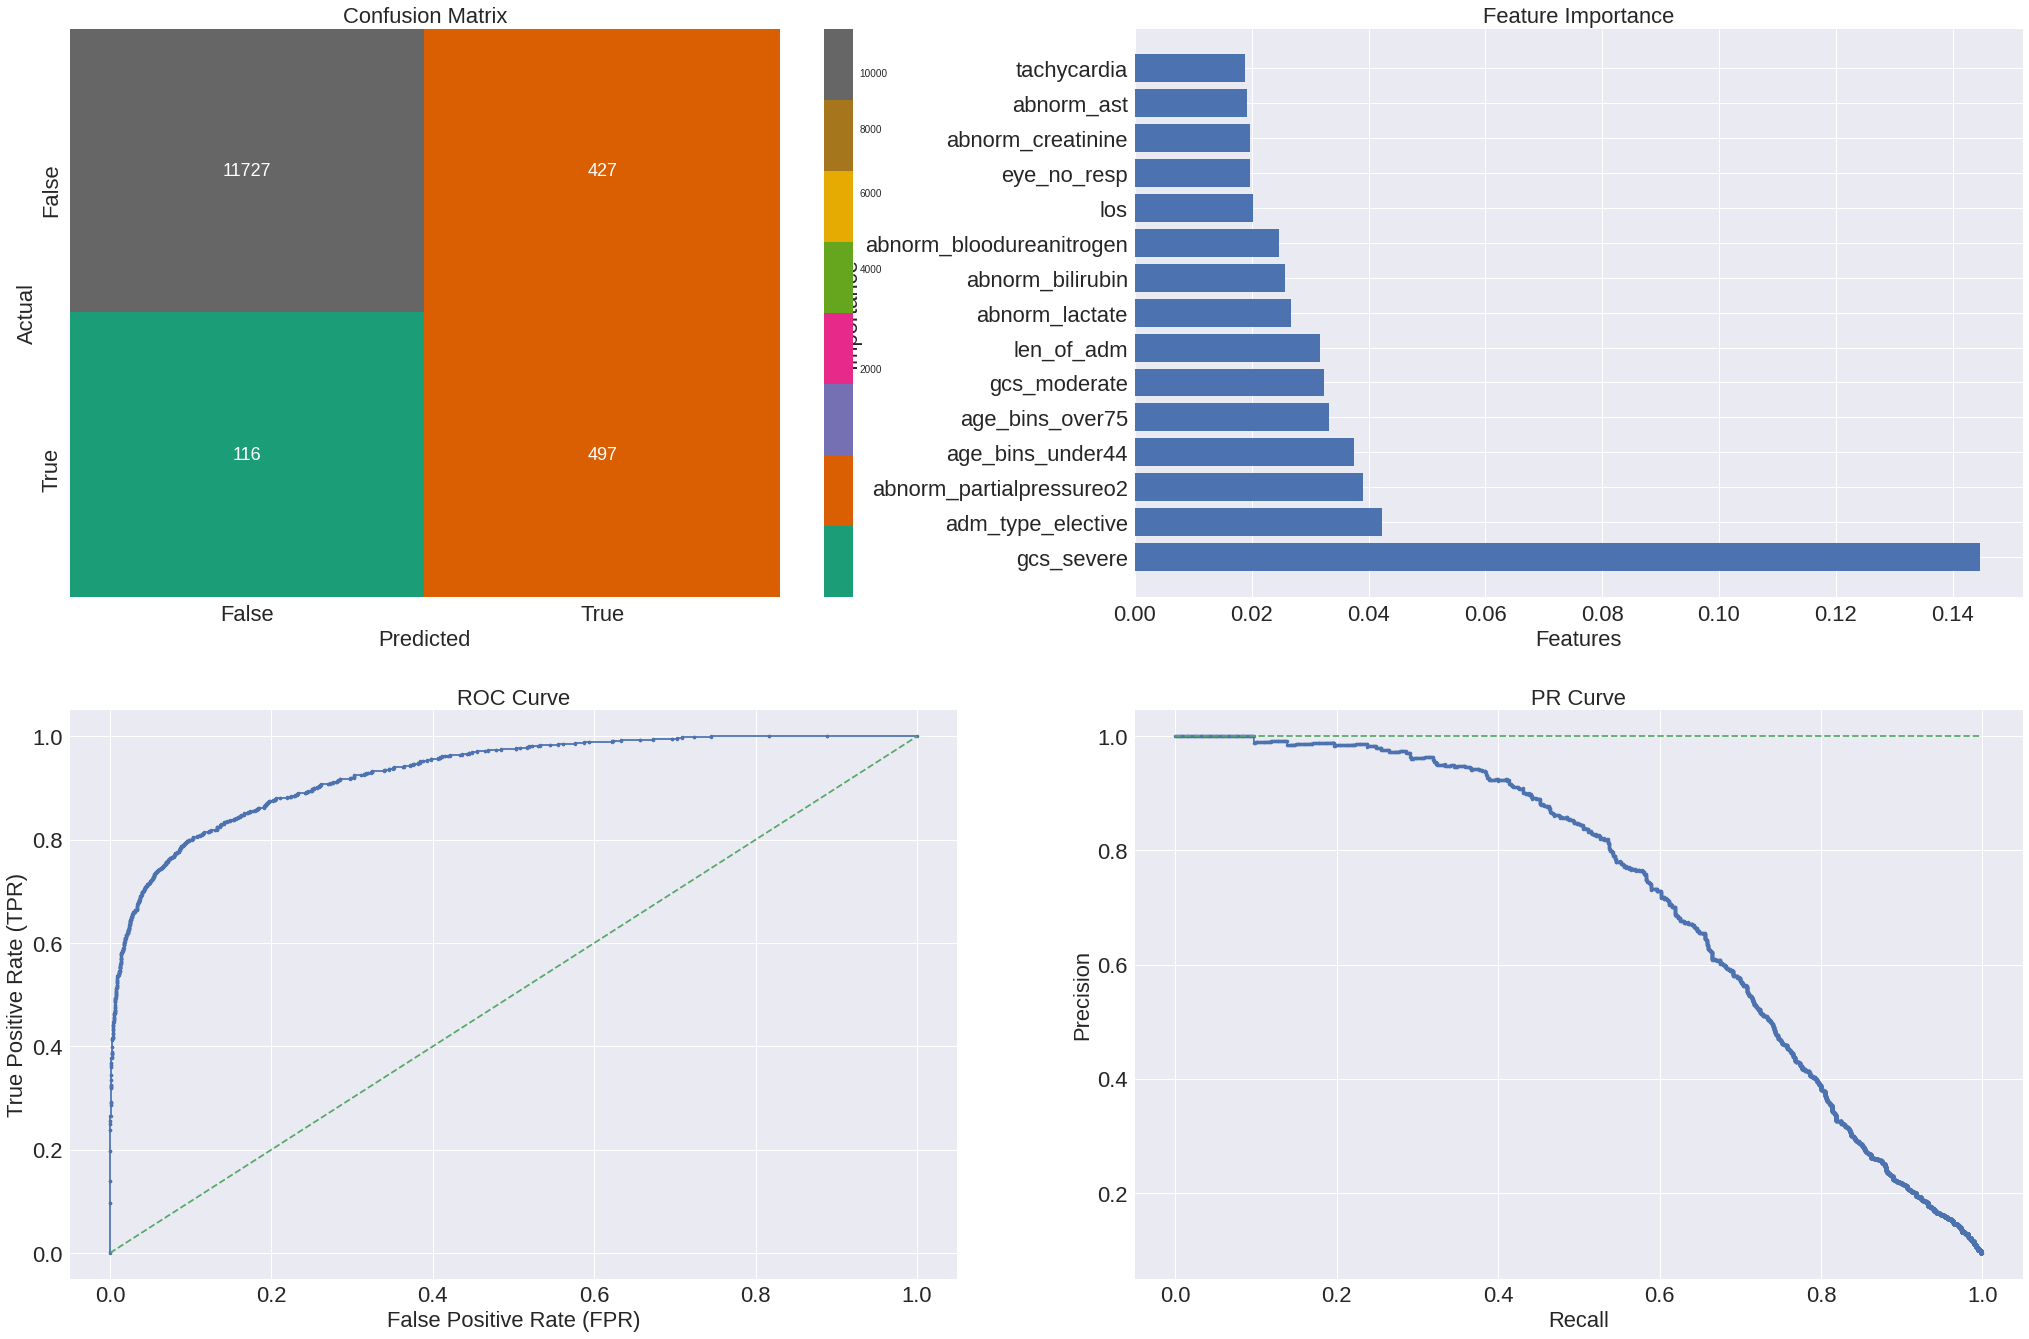

In [6]:
# Baseline models comparison
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.colors as colors
from xgboost import XGBClassifier

# Logistic Regression
LR = LogisticRegression(random_state=0, solver='liblinear', n_jobs=-1,)

# Randome Forest Classifier
# class weight is defined using outcome balance: 
# No. False cases/ No. True cases ~= 12 => {0:87, 1:12}
RFC = RandomForestClassifier(random_state=0, n_jobs=-1, class_weight={0:87, 1:12})

# Gradient Boosting Classifier from sklearn
GBC = GradientBoostingClassifier(random_state=0)

# Xtreme Gradient Boosting Classifier
# all hyper-parametes are defined following a step-by-step pruning process
# tree_method is set to gpu_hist which utilises GPU for faster computation 
# (only available in xgboost 1.5.x)
XGB = XGBClassifier(booster='gbtree', tree_method='gpu_hist', 
                    objective='binary:logistic',
                    eval_metric=['error','map','aucpr'],) 

algo_dict = {'Logistic Regression': LR,
             'Random Forest': RFC,
             'Gradient Boosted Tree': GBC,
             'XG Boost': XGB,}
labels = ['False', 'True']  # outcome values

# compare baseline models (except for XGBoost which is already tuned)     
# function baseline_model_performance from utils.py
baseline_model_performance(X, y, algo_dict, 
                           X_train_scaled, y_train, 
                           X_test_scaled, y_test, labels)

## Model Pruning (Hyper-parameter Tuning)



-------- Logistic Regression Tuned Model---------


Job took: 217.31969666481018s
Set of parameters from Exhaustive Grid Search CV:
 <bound method BaseEstimator.get_params of GridSearchCV(cv=StratifiedShuffleSplit(n_splits=7, random_state=0, test_size=0.3,
            train_size=None),
             estimator=Pipeline(steps=[('Transformer', StandardScaler()),
                                       ('Estimator',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=0,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'Estimator__C': [0.01, 0.1, 1, 10, 100],
                         'Estimator__class_weight': [{0: 1.0, 1: 0.0},
                                                     {0: 0.9, 1: 0.1},
                                                     {0:...
                                                     {0: 0.39999

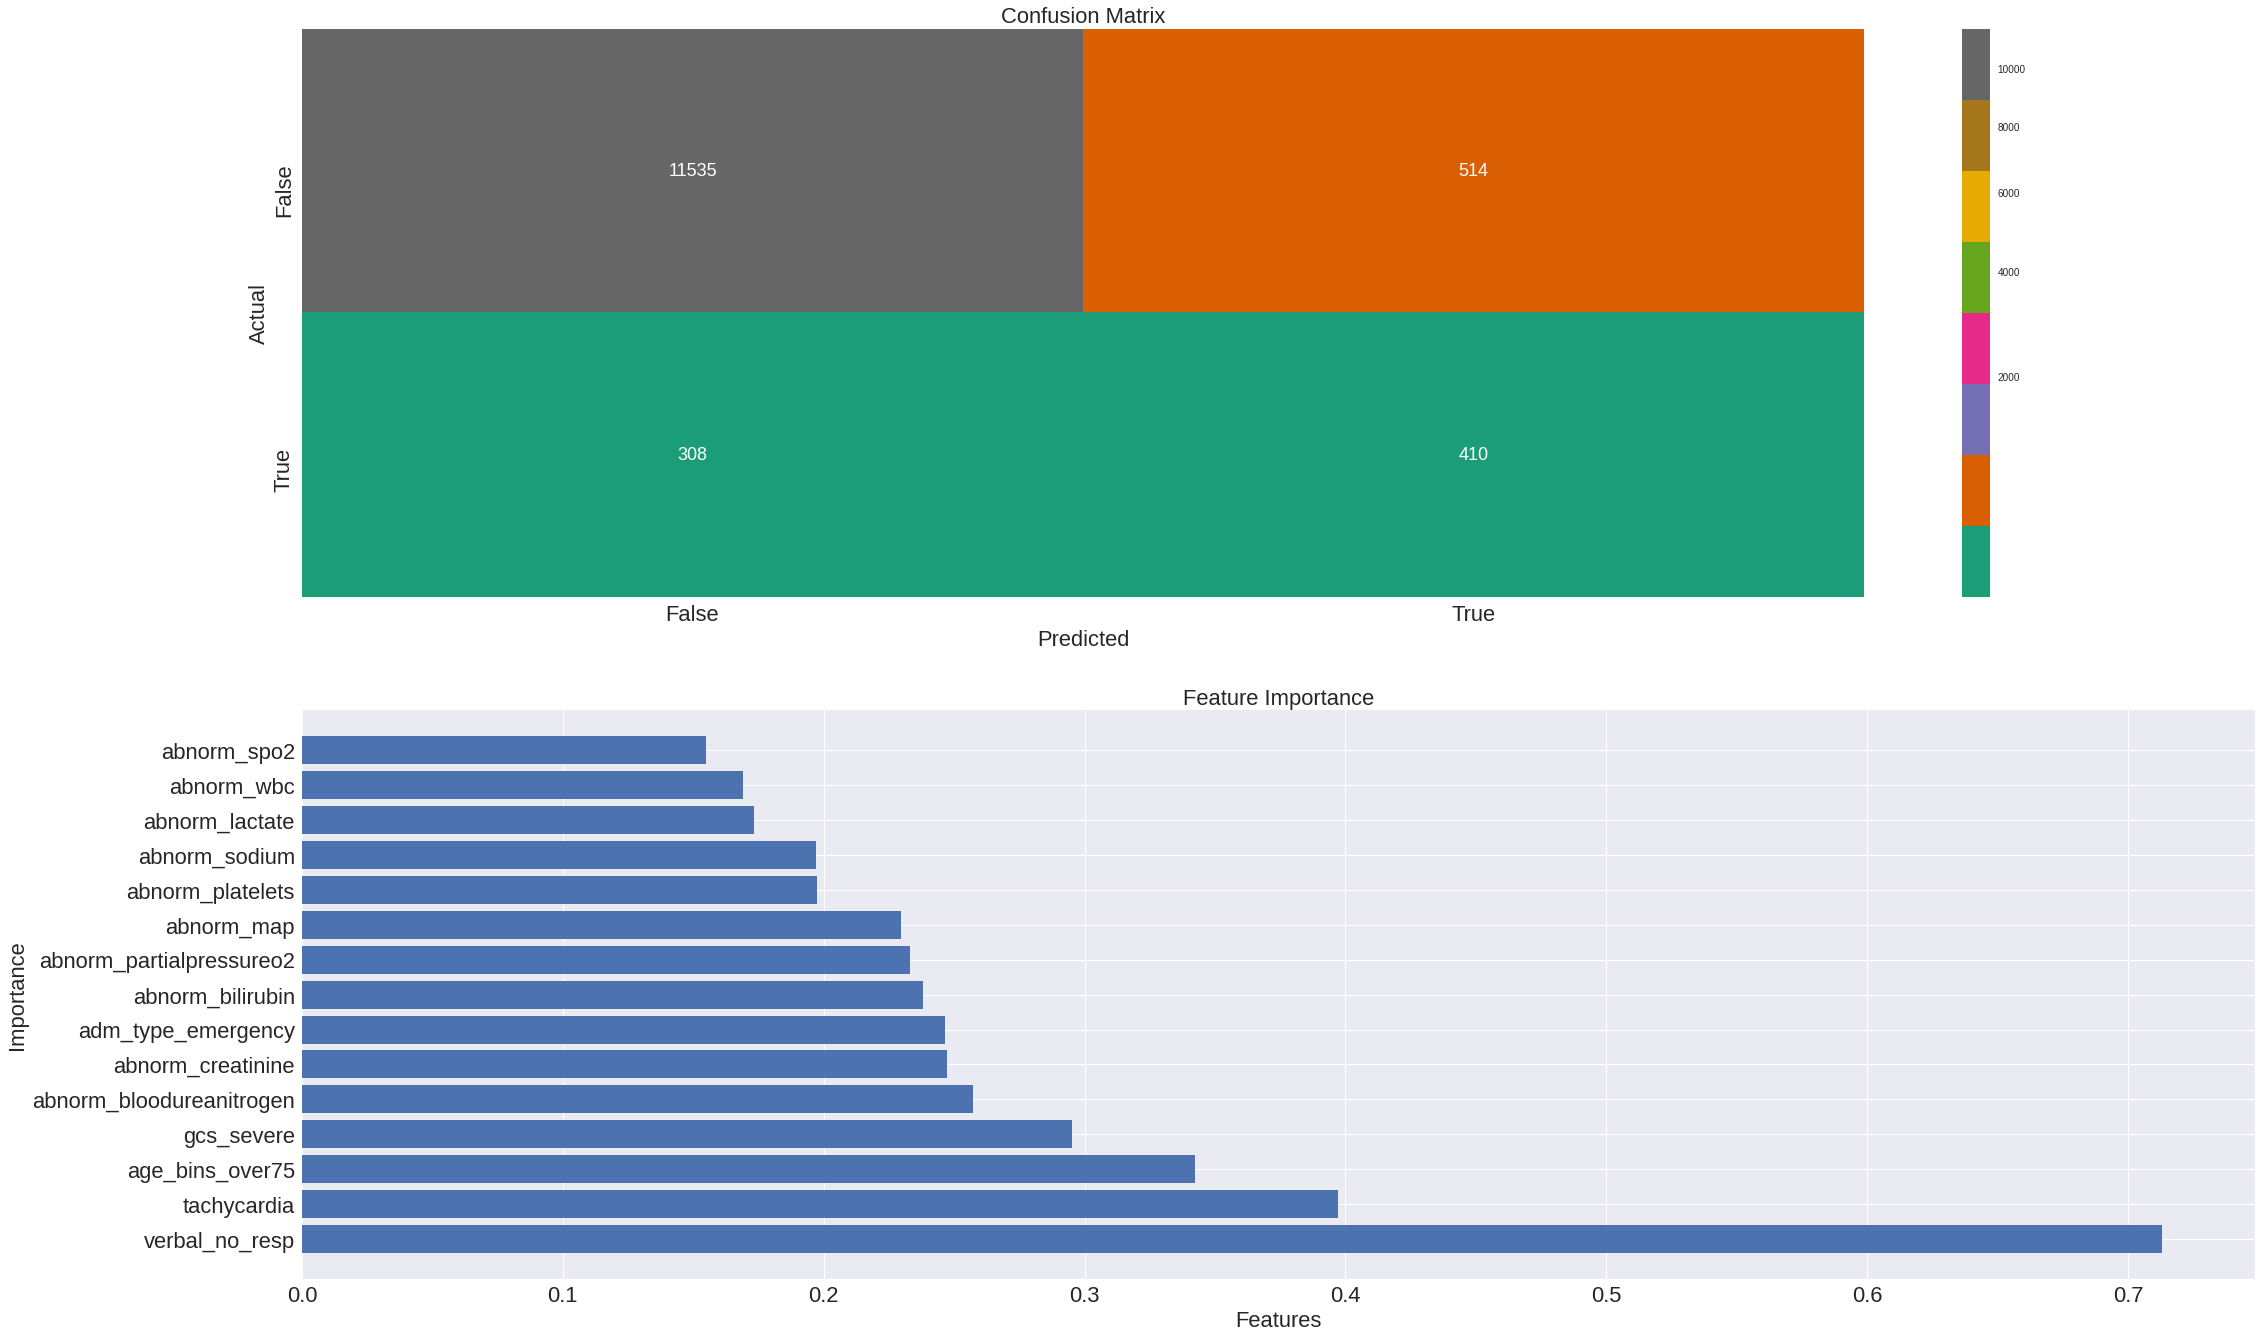



-------- Random Forest Tuned Model---------


Job took: 123.67899870872498s
Set of parameters from Exhaustive Grid Search CV:
 <bound method BaseEstimator.get_params of GridSearchCV(cv=StratifiedShuffleSplit(n_splits=7, random_state=0, test_size=0.3,
            train_size=None),
             estimator=Pipeline(steps=[('Transformer', StandardScaler()),
                                       ('Estimator',
                                        RandomForestClassifier(class_weight={0: 87,
                                                                             1: 12},
                                                               n_jobs=-1,
                                                               random_state=0))]),
             n_jobs=-1,
             param_grid={'Estimator__class_weight': [{0: 1.0, 1: 0.0},
                                                     {0: 0.9, 1: 0.1},
                                                     {0: 0.8, 1: 0.2},
                           

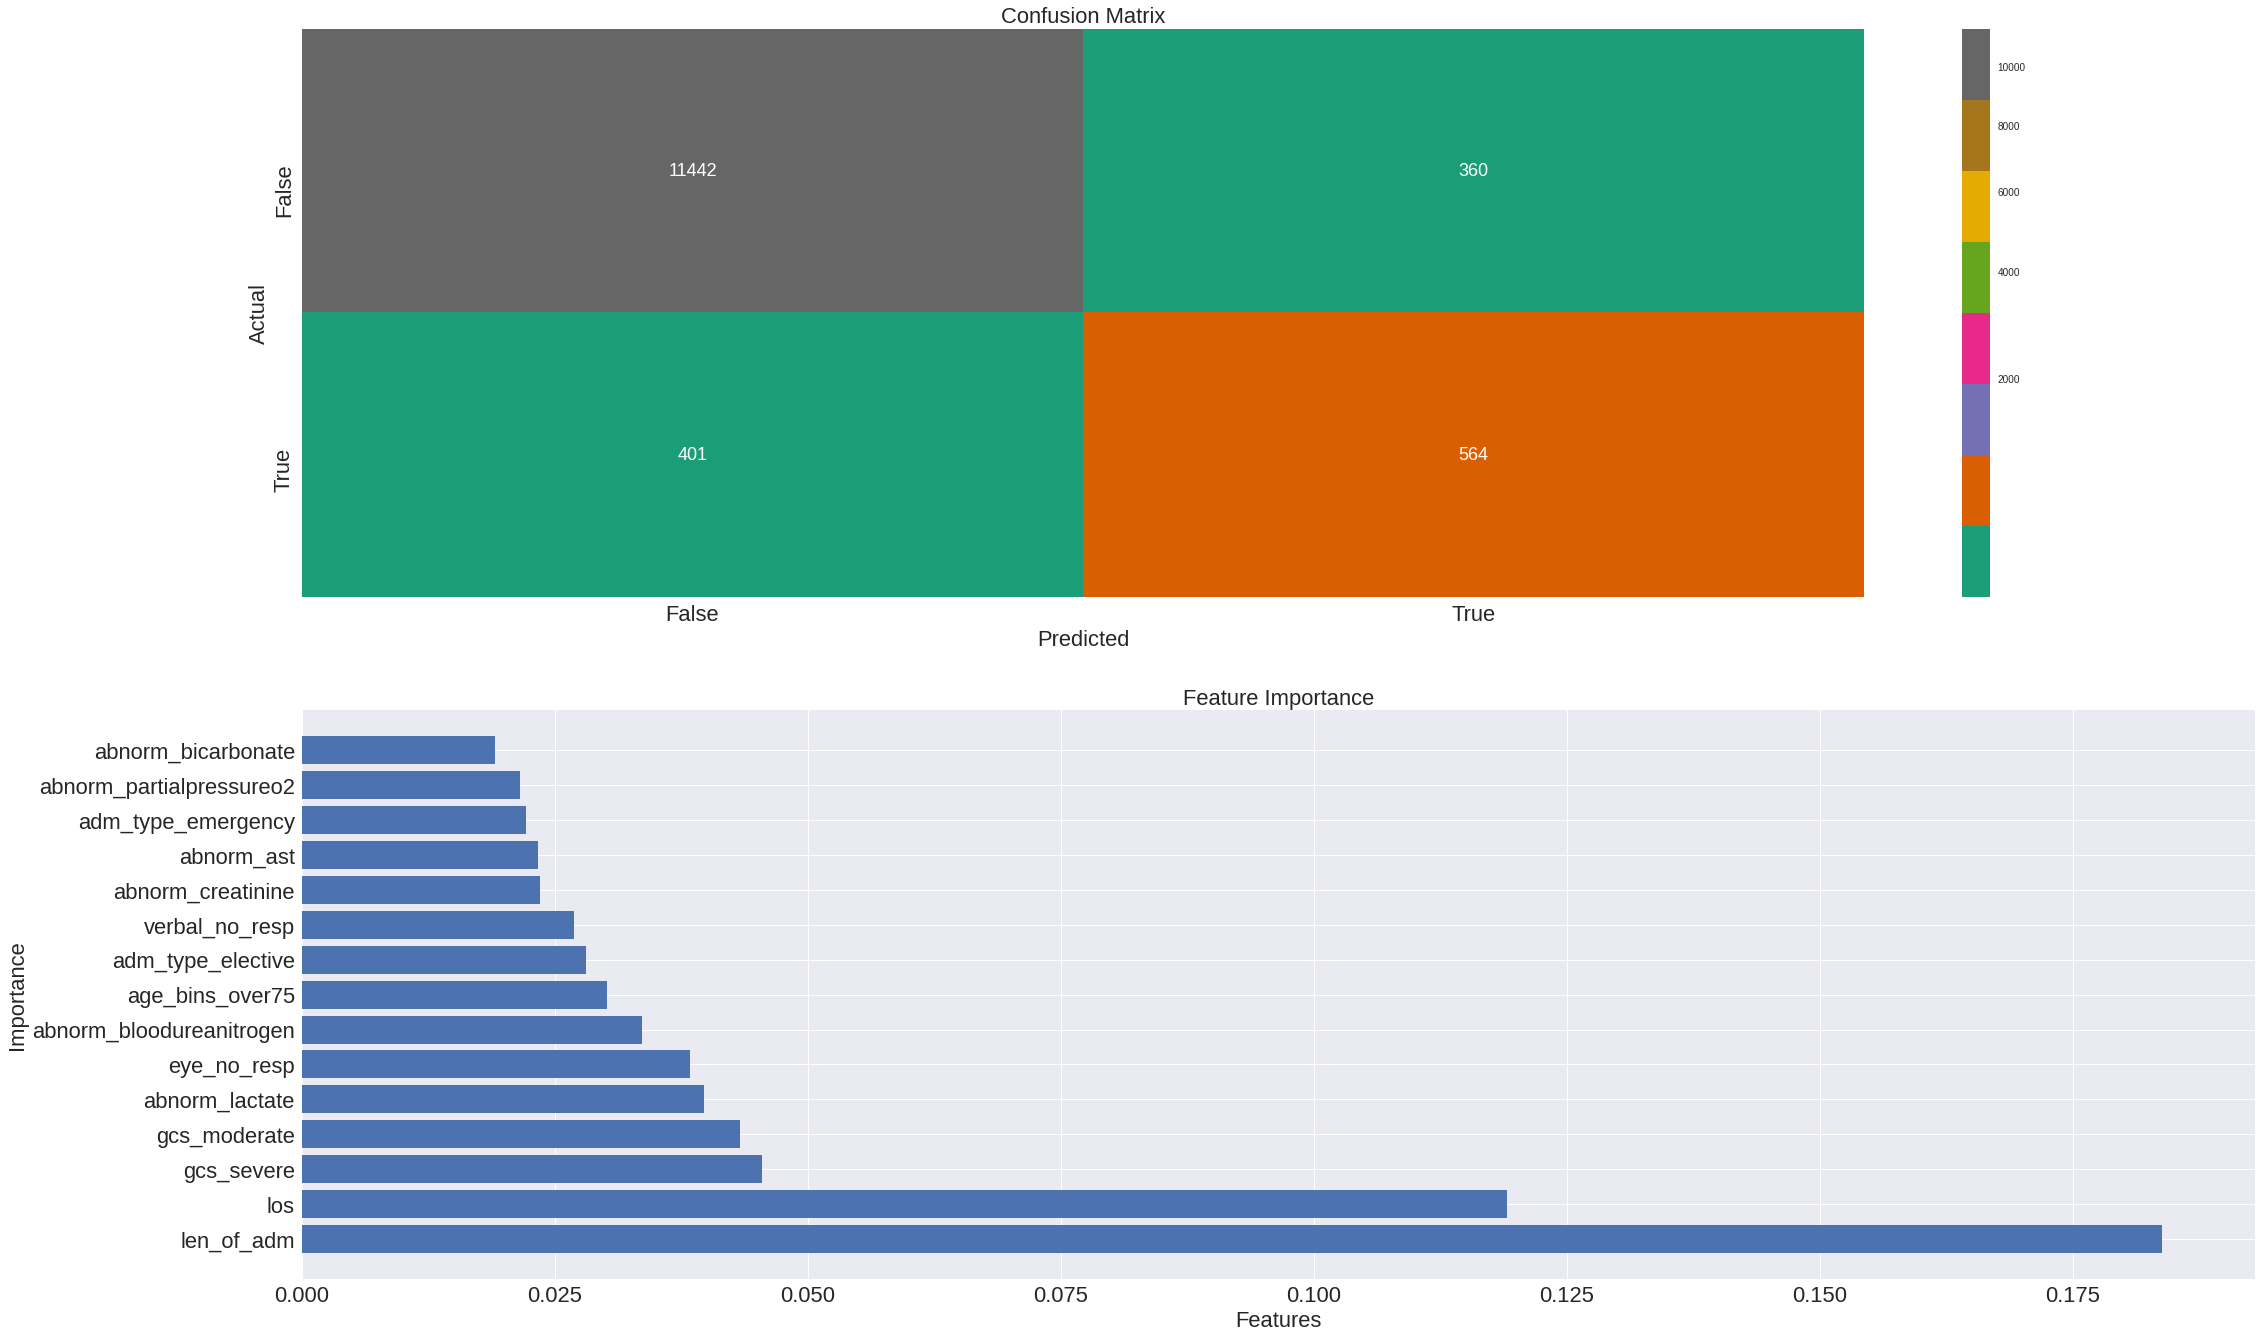



-------- Gradient Boosting Tuned Model---------


Job took: 261.83591079711914s
Set of parameters from Exhaustive Grid Search CV:
 <bound method BaseEstimator.get_params of GridSearchCV(cv=StratifiedShuffleSplit(n_splits=7, random_state=0, test_size=0.3,
            train_size=None),
             estimator=Pipeline(steps=[('Transformer', StandardScaler()),
                                       ('Estimator',
                                        GradientBoostingClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'Estimator__learning_rate': [0.01, 0.1, 0.2],
                         'Estimator__max_depth': range(4, 7),
                         'Estimator__n_estimators': [10, 100, 500]},
             refit='F1',
             scoring={'AP': make_scorer(average_precision_score),
                      'CK': make_scorer(cohen_kappa_score),
                      'F1': make_scorer(f1_score),
                      'MC': make_scorer(matthews_corrcoef)})>
Best para

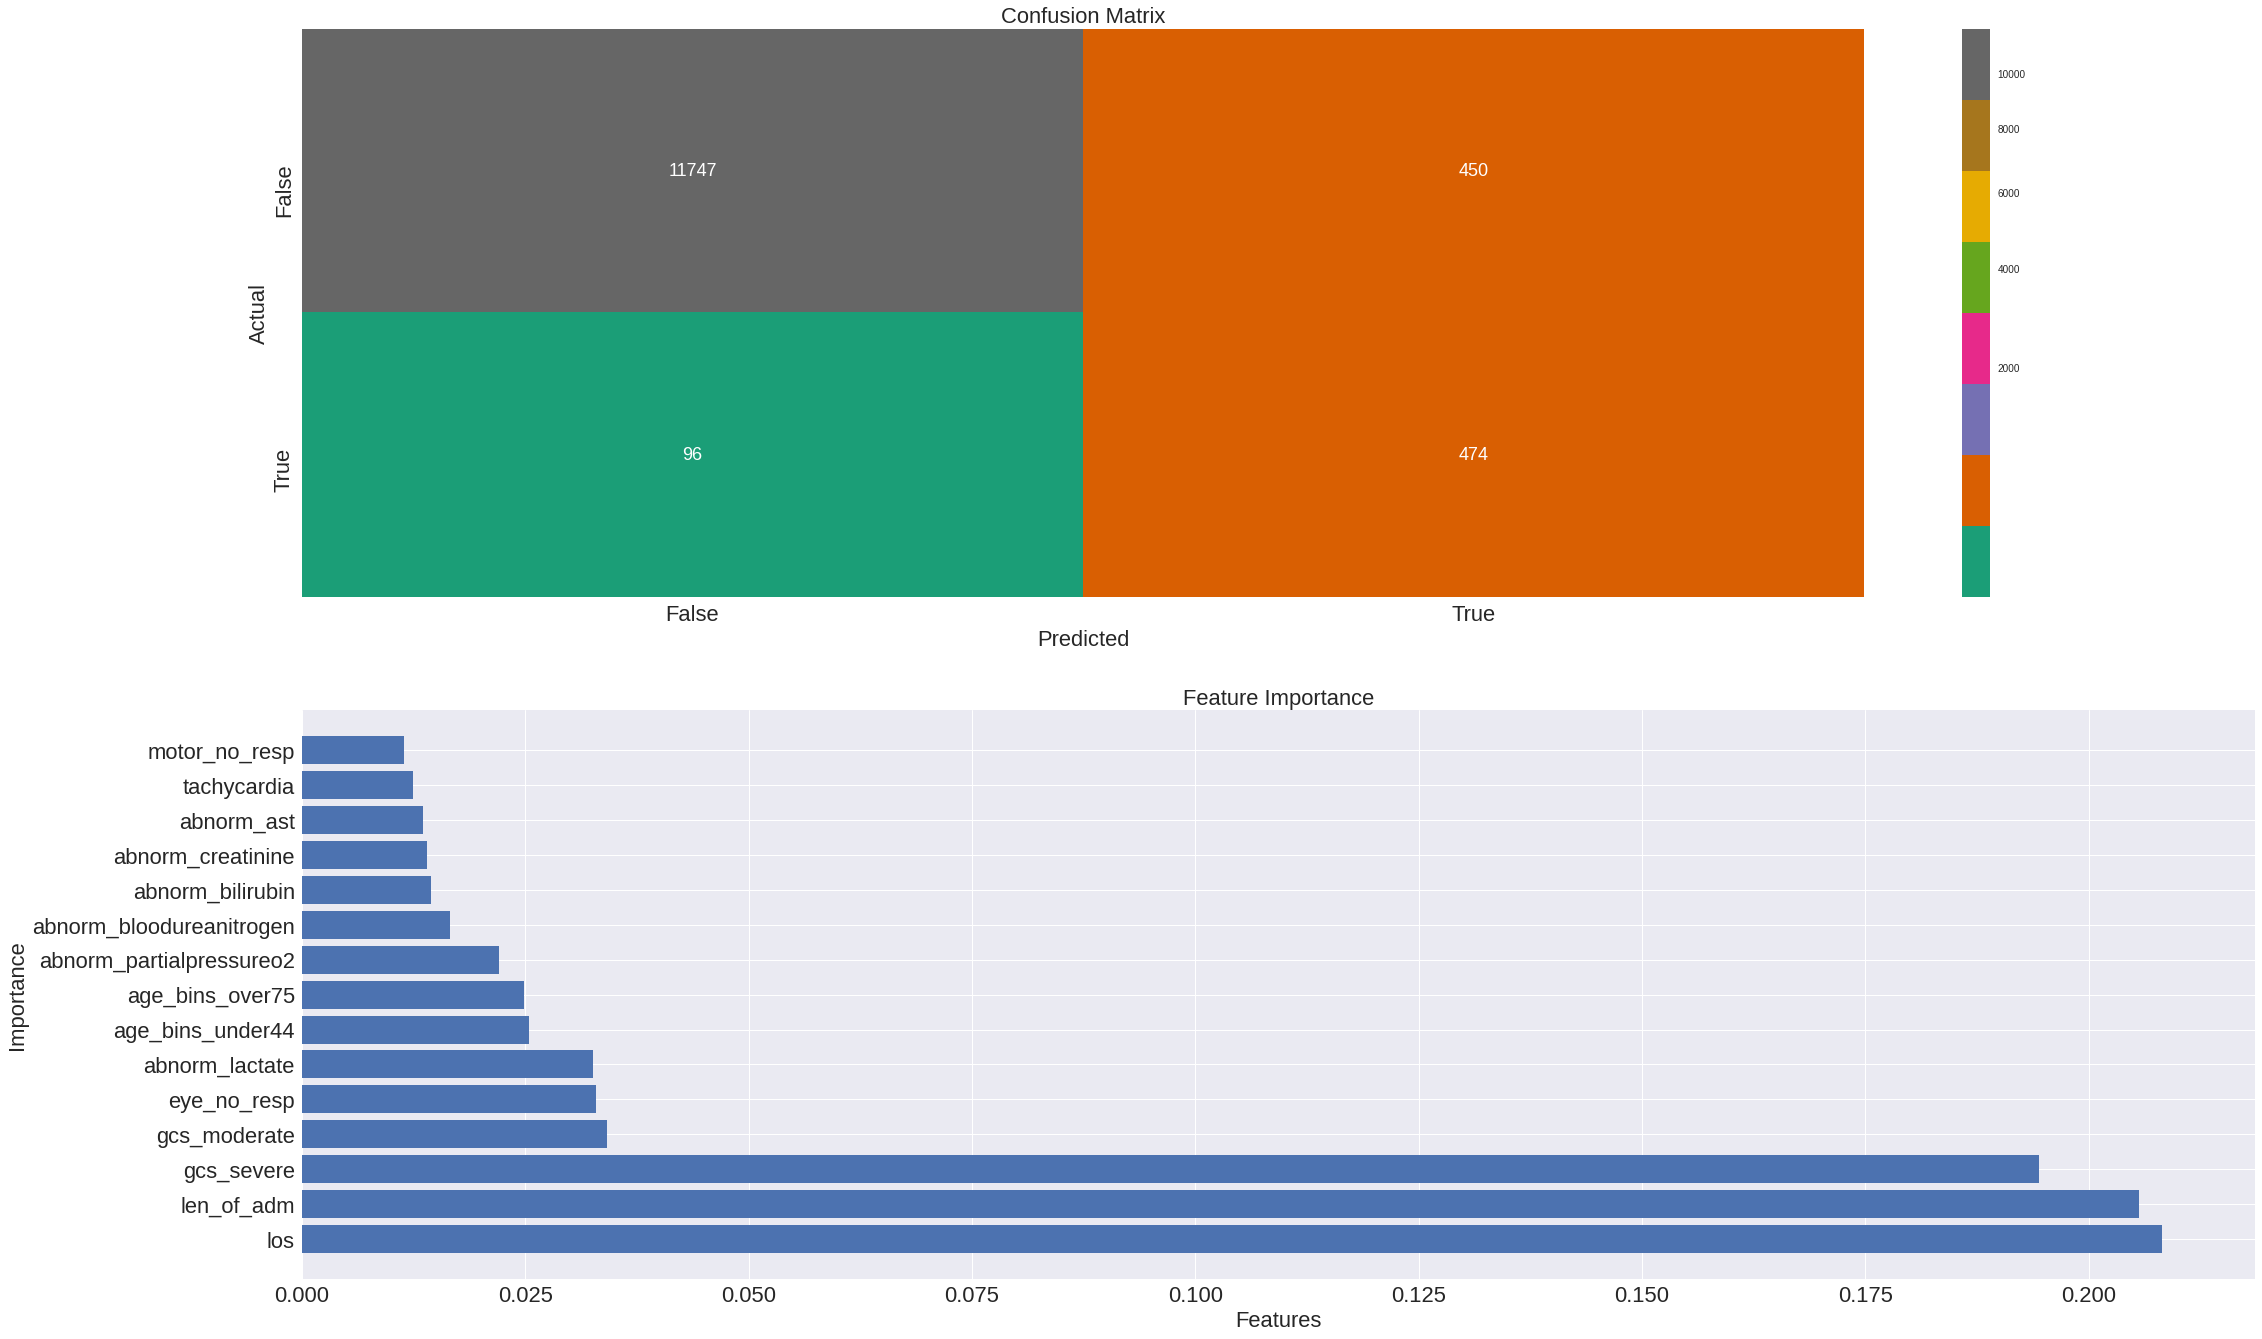



-------- Xtreme Gradient Boost Tuned Model---------


Job took: 131.11011481285095s
Set of parameters from Exhaustive Grid Search CV:
 <bound method BaseEstimator.get_params of GridSearchCV(cv=StratifiedShuffleSplit(n_splits=7, random_state=0, test_size=0.3,
            train_size=None),
             estimator=Pipeline(steps=[('Transformer', StandardScaler()),
                                       ('Estimator',
                                        XGBClassifier(base_score=None,
                                                      booster='gbtree',
                                                      colsample_bylevel=0.9,
                                                      colsample_bynode=None,
                                                      colsample_bytree=0.6,
                                                      eval_metric=['error',
                                                                   'auc',
                                                           

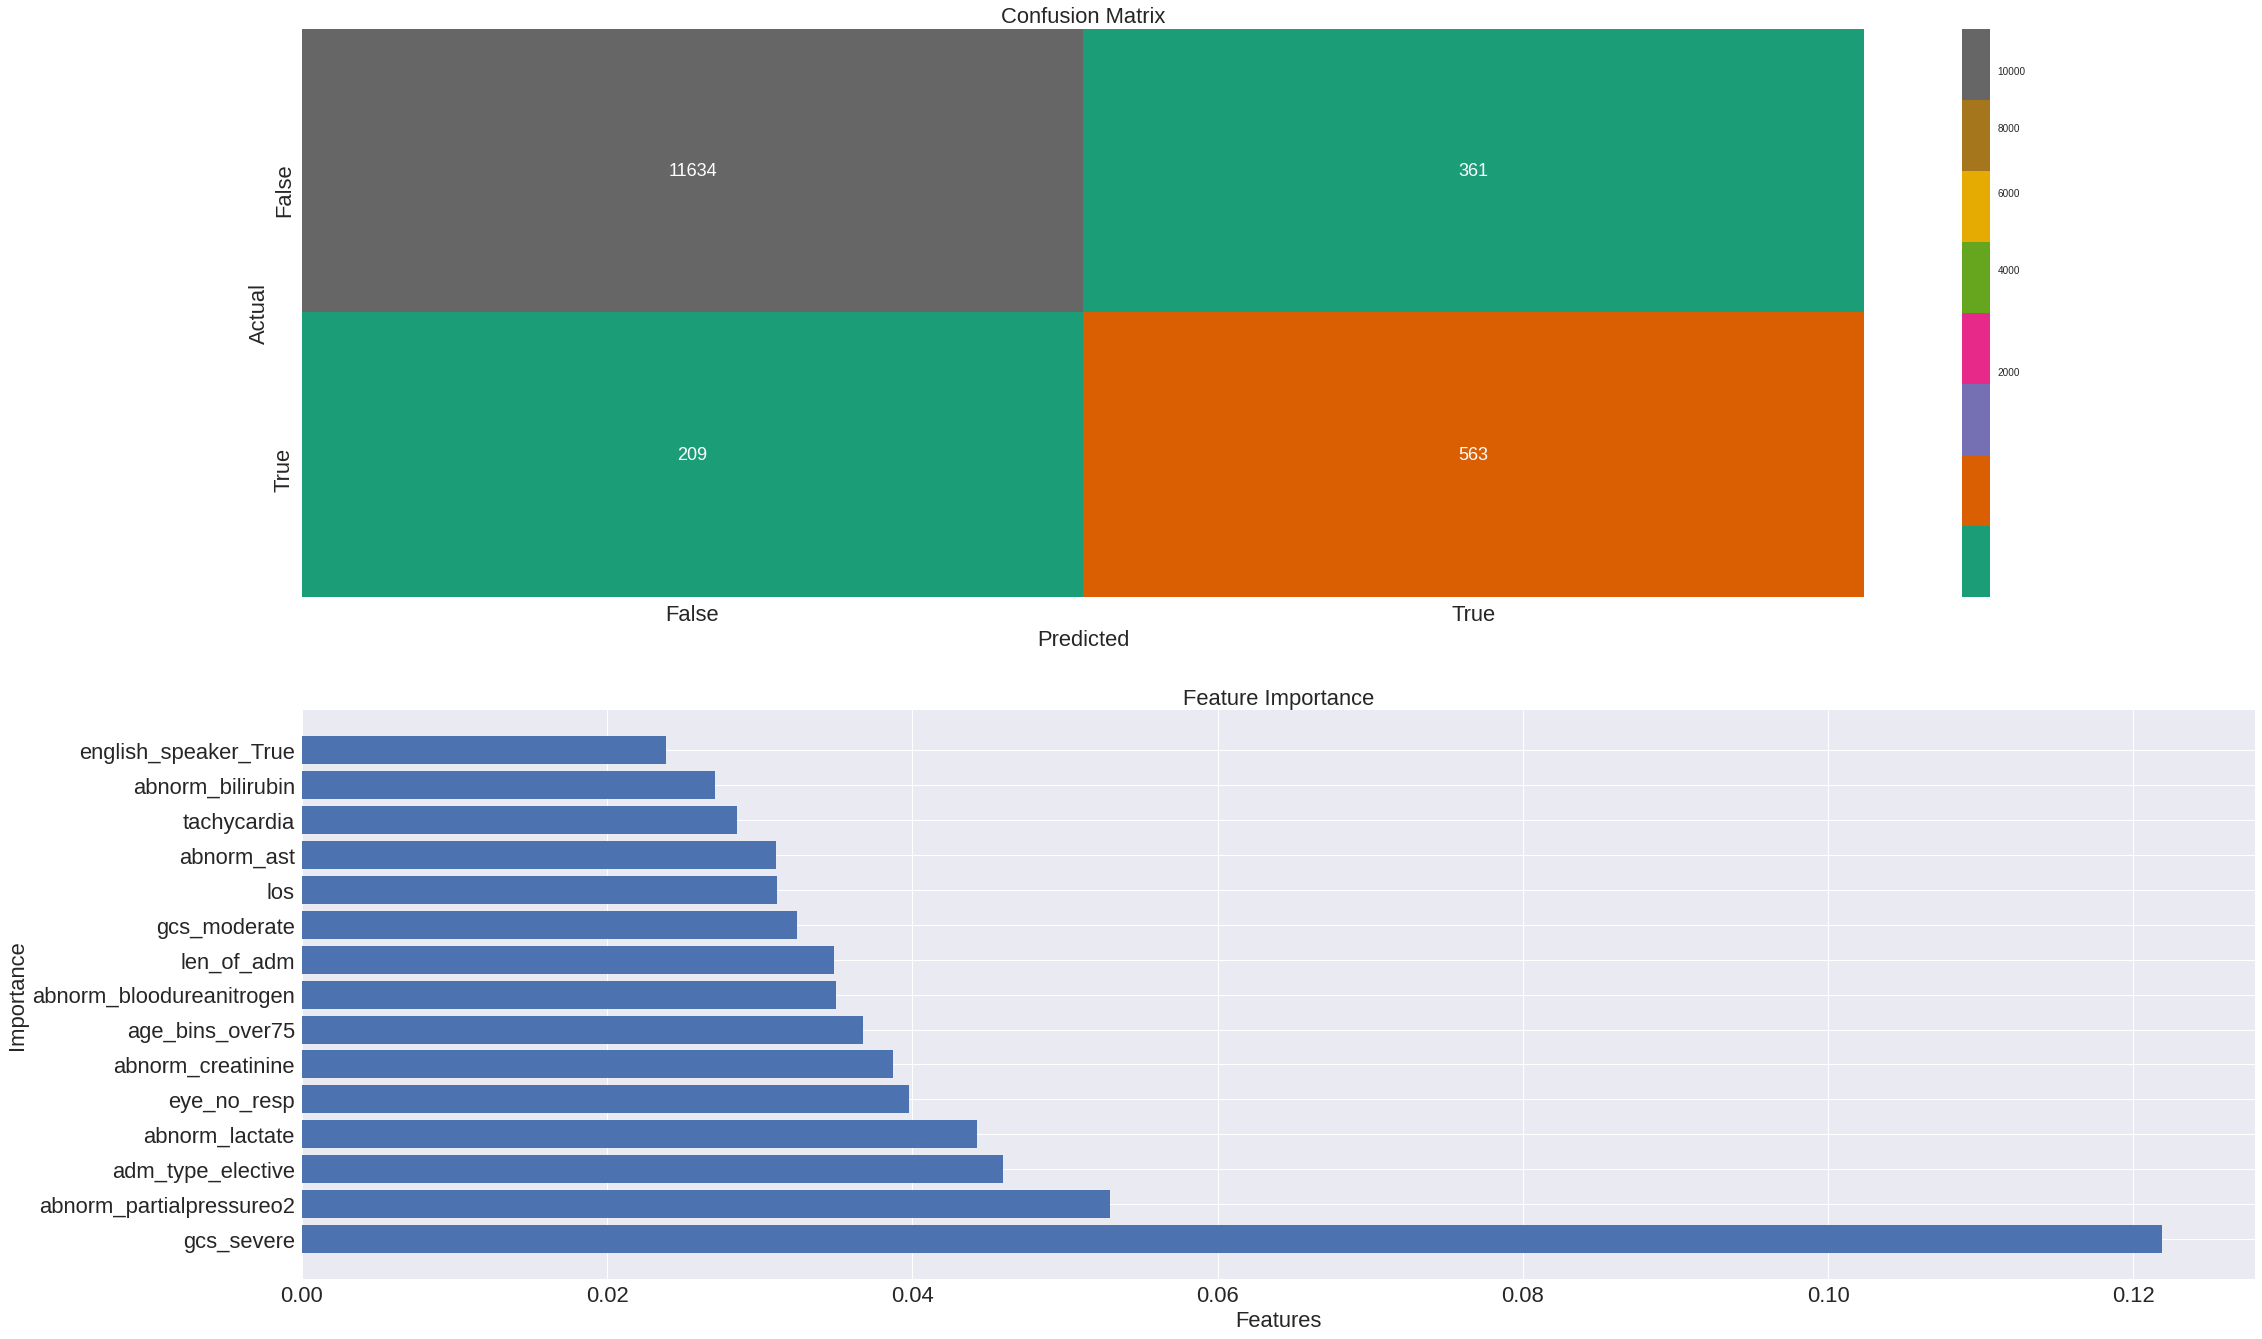

In [11]:
# Setting params for grid search CV

#Logistic Regression
param_grid_lg = {'Estimator__C': [ 0.01, 0.1, 1, 10, 100],
                 'Estimator__class_weight': [{1:w, 0:1-w} for w in np.linspace(0,1,11)],
                 'Estimator__penalty':['l1', 'l2'],}

#Random Forest
param_grid_rf = {'Estimator__max_depth': [10, 20, 30],
                 'Estimator__class_weight': [{1:w, 0:1-w} for w in np.linspace(0,1,11)],
                 'Estimator__n_estimators':[50, 80, 100],}

# Gradient Boosting Tree
param_grid_gbt = {'Estimator__learning_rate': [0.01, 0.1, 0.2],
                  'Estimator__n_estimators': [10, 100, 500],
                  'Estimator__max_depth': range(4,7,1)}

# Xtreme Gradient Boosting Tree
# Hyper-parameters were tuned separately and step-by-step in following order:
# scale_pos_weight -> learning_rate -> (subsample, colsample_bytree, colsample_bylevel) ->
# max_delta_step -> n_estimators -> sampling_method

XGB_pruned = XGBClassifier(booster='gbtree', tree_method='gpu_hist', 
                           objective='binary:logistic',
                           eval_metric=['error','auc','aucpr'],
                           subsample=1,
                           colsample_bylevel=0.9, 
                           colsample_bytree=0.6, 
                           learning_rate=0.3, 
                           scale_pos_weight=2, 
#                           gamma=0,
#                           max_depth=4,
                           reg_alpha=0, reg_lambda=1
                          ) 

param_grid_xgb = {
#     'Estimator__scale_pos_weight': list(range(1,10,1)),
#     'Estimator__learning_rate': np.linspace(0.1,0.5,5),
#     'Estimator__subsample': list(range(1,5,1)),
#     'Estimator__colsample_bytree':  np.linspace(0.5,1,6), 
#     'Estimator__colsample_bylevel': np.linspace(0.5,1,6),
#     'Estimator__max_delta_step': list(range(0,10,2)),
#     'Estimator__n_estimators': [100, 500, 1000],
#     'Estimator__sampling_method': ['uniform','gradient_based'],
     'Estimator__gamma': [0.0, 0.1, 0.2, 0.3],
     'Estimator__max_depth': list(range(0,10,1)),
#    'Estimator__reg_alpha':[0,1],
#    'Estimator__reg_lambda':[0,1]
}

# Selection of model to pass into the function
model_dict = {
     'Logistic Regression': {'clf':LR,'params':param_grid_lg},
     'Random Forest':  {'clf':RFC,'params':param_grid_rf},
     'Gradient Boosting':  {'clf':GBC,'params':param_grid_gbt},
     'Xtreme Gradient Boost':  {'clf':XGB_pruned,'params':param_grid_xgb},
    }

# labels, scaler and scoring already defined in previous chunks
tuned_models, models, time_used, best_cv_scores, \
roc_test_set, pr_test_set, f1_test_set,\
ap_test_set, mc_test_set, ck_test_set, acc_test_set, \
tn_count, fp_count, fn_count, tp_count, \
fpr_test_set, tpr_test_set, precision_test_set, recall_test_set =\
tuning_models_GSCV(X, y, X_train, y_train, X_test, y_test, 
                   labels, model_dict, scaler, scoring, refit_measure='F1') 

## Model Selection and Evaluation 

In [12]:
# Table final outcomes for comparison
model_outcome = \
pd.DataFrame.from_dict({'tuned_model_names':models,
                        'job_time_in_sec' :time_used,
                        'best_cv_score' :best_cv_scores,
                        'auc_roc_test_set' :roc_test_set,
                        'accuracy_test_set' :acc_test_set,
                        'pr_auc_test_set' :pr_test_set,
                        'f1_score_test_set' :f1_test_set,
                        'ap_test_set': ap_test_set,
                        'mc_test_set': mc_test_set,
                        'ck_test_set': ck_test_set,
                        'true_negatives' :tn_count,
                        'false_negatives' :fn_count,
                        'true_positives' :tp_count,
                        'false_positives' :fp_count,
                       }).set_index('tuned_model_names')


  
model_outcome.style.apply(highlight_max, 
                          subset=['best_cv_score', 'auc_roc_test_set', 'accuracy_test_set',
                                  'pr_auc_test_set', 'f1_score_test_set', 'ap_test_set',
                                  'mc_test_set', 'ck_test_set','true_negatives', 'true_positives']).\
                    apply(highlight_min,
                          subset=['job_time_in_sec','false_positives', 'false_negatives'])

,job_time_in_sec,best_cv_score,auc_roc_test_set,accuracy_test_set,pr_auc_test_set,f1_score_test_set,ap_test_set,mc_test_set,ck_test_set,true_negatives,false_negatives,true_positives,false_positives
tuned_model_names,,,,,,,,,,,,,
Logistic Regression,217.319697,0.528663,0.872011,0.935615,0.537765,0.499391,0.537978,0.469797,0.465564,11535,308,410,514
Random Forest,123.678999,0.609110,0.921501,0.940393,0.665414,0.597141,0.665546,0.565129,0.564973,11442,401,564,360
Gradient Boosting,261.835911,0.640581,0.936549,0.957233,0.725574,0.634538,0.725674,0.633420,0.613176,11747,96,474,450
Xtreme Gradient Boost,131.110115,0.665493,0.937364,0.955354,0.727616,0.663915,0.727717,0.643176,0.640209,11634,209,563,361


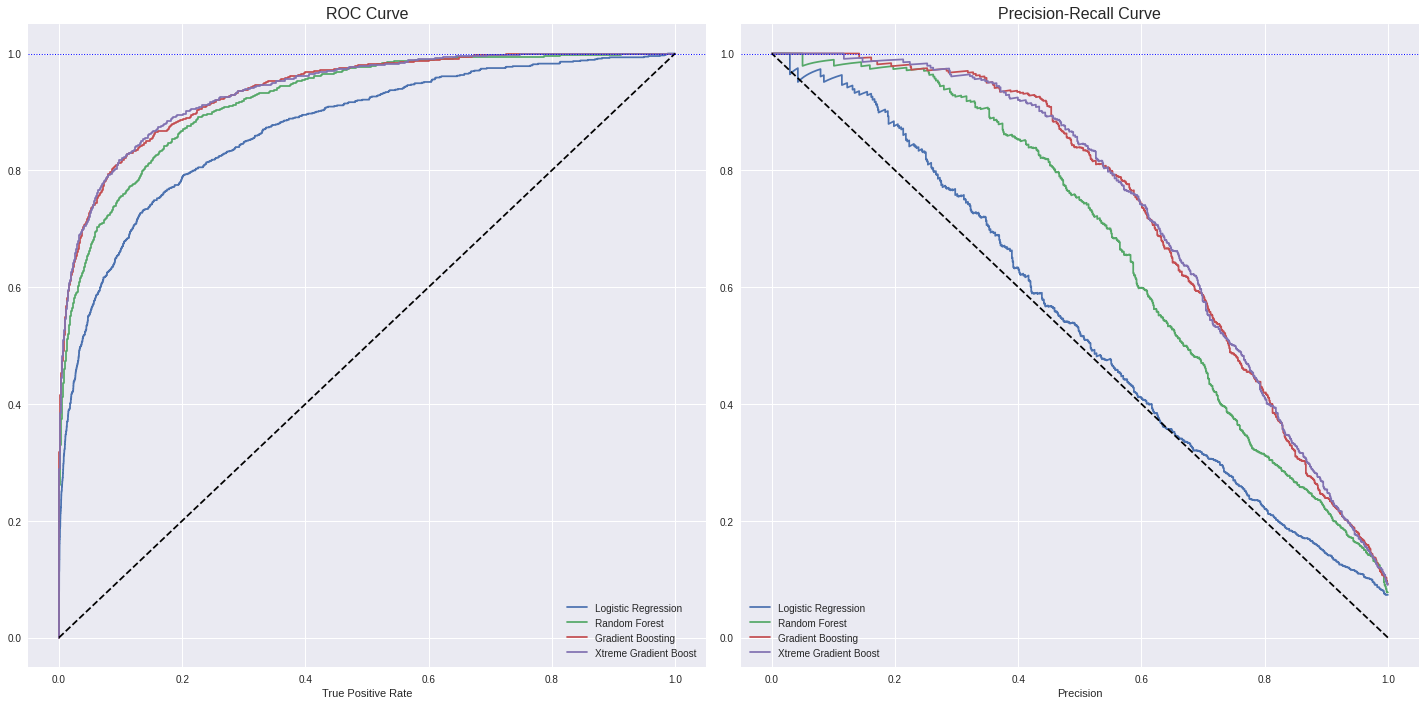

In [13]:
# ROC and PR curves
fig, ax= plt.subplots(1, 2, figsize=(20,10))

ax6 = ax[0]
ax6.set_title('ROC Curve', fontsize=16)
ax7=ax[1]
ax7.set_title('Precision-Recall Curve', fontsize=16)
for i in range(len(fpr_test_set)):
    # Plot ROC Curves
    ax6.plot(fpr_test_set[i], tpr_test_set[i], linestyle='-', 
             label=model_outcome.index[i],)
    # Plot Precision-Recall Curve
    ax7.plot(recall_test_set[i], precision_test_set[i],linestyle='-', 
             label=model_outcome.index[i],)
ax6.plot([0, 1], [0, 1], linestyle='--', color='black')
ax6.axhline(y=1, linestyle=':', linewidth=1, color='blue')
ax6.set_xlabel('False Positive Rate')
ax6.set_xlabel('True Positive Rate')
ax6.legend()

ax7.plot([1, 0], [0, 1], linestyle='--', color='black')
ax7.axhline(y=1, linestyle=':', linewidth=1, color='blue')
ax7.set_xlabel('Recall')
ax7.set_xlabel('Precision')
ax7.legend()

fig.tight_layout()
plt.show()

In [14]:
# save the model to directory 'final_model'
filename0 = 'final_model/xgb_model.pkl'
pickle.dump(tuned_models[-1], open(filename0, 'wb'))
filename1 = 'final_model/gbt_model.pkl'
pickle.dump(tuned_models[-2], open(filename1, 'wb'))